## L&T EduTech Hackathon: Problem Statement 1
Deep Learning framework for Crack Detection

In [2]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow_addons.metrics import F1Score

import matplotlib.pyplot as plt

In [3]:
# Config Variables
DIR = "./Surface Crack" # Replace with Path to Data Folder

## Load Data

In [6]:
def load_images(directory, subset, batch_size=32, image_size=(224, 224), shuffle=False):
    directory = os.path.join(directory, subset)
    return image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        class_names=['Negative','Positive'],
        color_mode="rgb",
        batch_size=batch_size,
        image_size=image_size,
        shuffle=shuffle,
    ).cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_ds = load_images(DIR, 'train', shuffle=True)
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
valid_ds = load_images(DIR, 'valid', shuffle=True)
print("Number of validation samples: %d" % tf.data.experimental.cardinality(valid_ds))
test_ds = load_images(DIR, 'test', shuffle=True)
print("Number of testing samples: %d" % tf.data.experimental.cardinality(test_ds))

Found 600 files belonging to 2 classes.
Number of training samples: 19
Found 200 files belonging to 2 classes.
Number of validation samples: 7
Found 200 files belonging to 2 classes.
Number of testing samples: 7


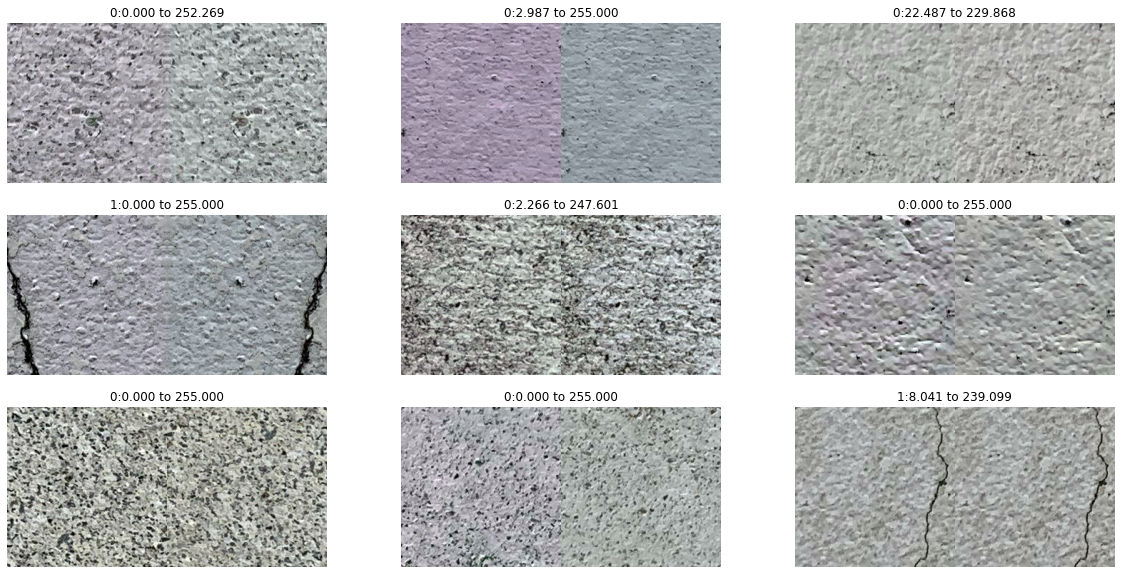

In [7]:
# Sample the loaded images and apply augmentations
plt.figure(figsize=(20, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    x = image[-1]
    x = tf.image.random_brightness(x, 5)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    x = tf.image.random_hue(x, 0.3)
    x = tf.image.random_saturation(x, 0.7, 1.3)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = tf.clip_by_value(x, clip_value_min=0, clip_value_max=255)
    plt.imshow(np.concatenate([x,image[-1]],axis=1)/255.0)
    plt.title(f"{int(label[-1])}:{np.min(x):.3f} to {np.max(x):.3f}")
    plt.axis("off")

## Deep Learning Model
Handling special case of MobileNetV3 family of models
- Preprocessing is built in to model
- Accepts float input of [0-255] range
- Additional parameters of `alpha` and `minimalistic`

In [8]:
#@title Select model architecture
#@markdown Provided are the models that performed well in initial round

model_name = "MobileNetV3Large"  #@param ['MobileNetV3Small','MobileNetV3Large']

model_type = "1.0"  #@param ['1.0','0.75','minimalistic_1.0']

model_dict = {
    'MobileNetV3Small': tf.keras.applications.MobileNetV3Small,
    'MobileNetV3Large': tf.keras.applications.MobileNetV3Large
}

minimalistic = "minimalistic" in model_type
alpha = 1.0 if "1.0" in model_type else 0.75

model = model_dict[model_name]

In [9]:
INPUT_SHAPE = (224, 224, 3)
base_model = model(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    minimalistic=minimalistic,
    alpha=alpha,
    input_shape=INPUT_SHAPE,
    include_top=False,
    pooling='avg'
)

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=INPUT_SHAPE)

# Pre-trained Xception weights requires that input be preprocessed

# Augmentation
x = tf.image.random_brightness(inputs, 5)
x = tf.image.random_contrast(x, 0.7, 1.3)
x = tf.image.random_hue(x, 0.3)
x = tf.image.random_saturation(x, 0.7, 1.3)
x = tf.image.random_flip_left_right(x)
x = tf.image.random_flip_up_down(x)
# x = tf.image.random_jpeg_quality(x, 50, 99) # Can't apply as floats are expected to be in [0,1) range
if "MobileNet" in model_name:
    x = tf.clip_by_value(x, clip_value_min=0, clip_value_max=255) # For MobiNet Only

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

model.summary(show_trainable=True)

12683000/12683000 [==============================] - 2s 0us/step
Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 tf.image.adjust_brightness   (None, 224, 224, 3)      0         Y          
 (TFOpLambda)                                                               
                                                                            
 tf.image.adjust_contrast (T  (None, 224, 224, 3)      0         Y          
 FOpLambda)                                                                 
                                                                            
 tf.image.adjust_hue (TFOpLa  (None, 224, 224, 3)      0         Y          
 mbda)                                                                   

In [10]:
%%time
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    f"{model_name}_{model_type}_best_val_f1_score.h5",
    monitor='val_f1_score',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), F1Score(1, 'micro', threshold=0.5)]
)

epochs = 40
history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, verbose=2, callbacks=[model_checkpoint_callback])

Epoch 1/40
19/19 - 14s - loss: 0.5055 - accuracy: 0.7417 - precision: 0.6644 - recall: 0.9767 - f1_score: 0.7908 - val_loss: 0.2935 - val_accuracy: 0.9700 - val_precision: 0.9608 - val_recall: 0.9800 - val_f1_score: 0.9703 - 14s/epoch - 719ms/step
Epoch 2/40
19/19 - 1s - loss: 0.2456 - accuracy: 0.9717 - precision: 0.9670 - recall: 0.9767 - f1_score: 0.9718 - val_loss: 0.1558 - val_accuracy: 0.9850 - val_precision: 0.9802 - val_recall: 0.9900 - val_f1_score: 0.9851 - 1s/epoch - 62ms/step
Epoch 3/40
19/19 - 1s - loss: 0.1544 - accuracy: 0.9767 - precision: 0.9799 - recall: 0.9733 - f1_score: 0.9766 - val_loss: 0.1129 - val_accuracy: 0.9800 - val_precision: 0.9800 - val_recall: 0.9800 - val_f1_score: 0.9800 - 991ms/epoch - 52ms/step
Epoch 4/40
19/19 - 1s - loss: 0.1266 - accuracy: 0.9700 - precision: 0.9796 - recall: 0.9600 - f1_score: 0.9697 - val_loss: 0.0903 - val_accuracy: 0.9900 - val_precision: 0.9804 - val_recall: 1.0000 - val_f1_score: 0.9901 - 1s/epoch - 61ms/step
Epoch 5/40
19/

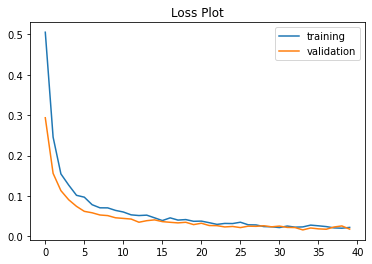

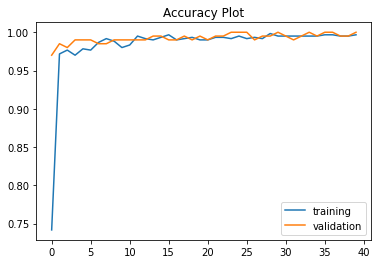

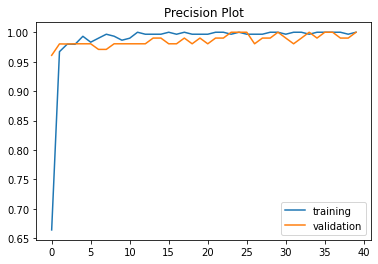

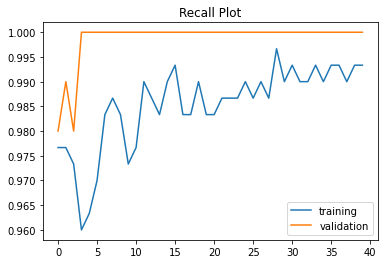

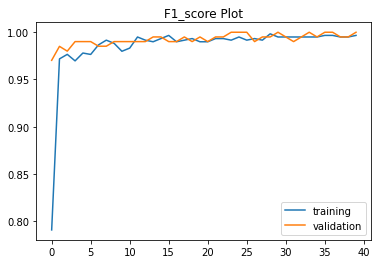

In [11]:
def plot_curves(history):
    metrics = [metric for metric in history.history if not metric.startswith('val')]
    val_metrics = {metric for metric in history.history if metric.startswith('val')}
    for metric in metrics:
        plt.figure()
        plt.plot(history.epoch, history.history[metric], label="training")
        val_metric = 'val_' + metric
        if val_metric in val_metrics:
            plt.plot(history.epoch, history.history[val_metric], label="validation")
        plt.title(f"{metric.capitalize()} Plot")
        plt.legend(loc="best")

plot_curves(history)

In [12]:
# Evaluate the model on Test set using best model
model.load_weights(f"{model_name}_{model_type}_best_val_f1_score.h5")
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), F1Score(1, 'micro', threshold=0.5)]
)
results = model.evaluate(test_ds, verbose=2)

7/7 - 2s - loss: 0.0643 - accuracy: 0.9900 - precision: 0.9804 - recall: 1.0000 - f1_score: 0.9901 - 2s/epoch - 223ms/step


## Final Fine Tuning of Model
Unfreeze the base_model and fine tune the model at a low learning rate.

In [13]:
base_model.trainable = True
model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 tf.image.adjust_brightness   (None, 224, 224, 3)      0         Y          
 (TFOpLambda)                                                               
                                                                            
 tf.image.adjust_contrast (T  (None, 224, 224, 3)      0         Y          
 FOpLambda)                                                                 
                                                                            
 tf.image.adjust_hue (TFOpLa  (None, 224, 224, 3)      0         Y          
 mbda)                                                                      
                                                             

In [14]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    f"{model_name}_{model_type}_finetuned_best_val_f1_score.h5",
    monitor='val_f1_score',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6), # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), F1Score(1, 'micro', threshold=0.5)]
)

epochs = 40
history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, verbose=2, callbacks=[model_checkpoint_callback])

Epoch 1/40
19/19 - 14s - loss: 0.0287 - accuracy: 0.9967 - precision: 1.0000 - recall: 0.9933 - f1_score: 0.9967 - val_loss: 0.0288 - val_accuracy: 0.9900 - val_precision: 0.9804 - val_recall: 1.0000 - val_f1_score: 0.9901 - 14s/epoch - 740ms/step
Epoch 2/40
19/19 - 4s - loss: 0.0251 - accuracy: 0.9933 - precision: 0.9966 - recall: 0.9900 - f1_score: 0.9933 - val_loss: 0.0195 - val_accuracy: 0.9950 - val_precision: 0.9901 - val_recall: 1.0000 - val_f1_score: 0.9950 - 4s/epoch - 219ms/step
Epoch 3/40
19/19 - 4s - loss: 0.0208 - accuracy: 0.9950 - precision: 0.9967 - recall: 0.9933 - f1_score: 0.9950 - val_loss: 0.0234 - val_accuracy: 0.9900 - val_precision: 0.9804 - val_recall: 1.0000 - val_f1_score: 0.9901 - 4s/epoch - 202ms/step
Epoch 4/40
19/19 - 4s - loss: 0.0213 - accuracy: 0.9967 - precision: 1.0000 - recall: 0.9933 - f1_score: 0.9967 - val_loss: 0.0185 - val_accuracy: 0.9950 - val_precision: 0.9901 - val_recall: 1.0000 - val_f1_score: 0.9950 - 4s/epoch - 201ms/step
Epoch 5/40
19/

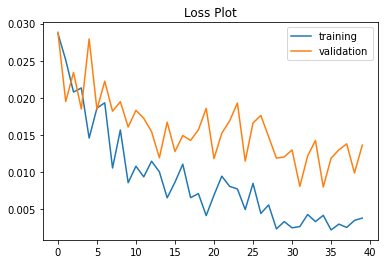

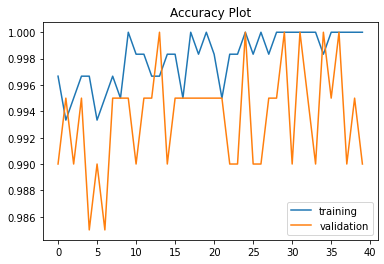

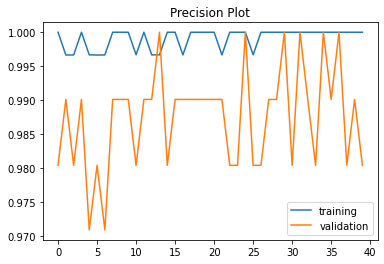

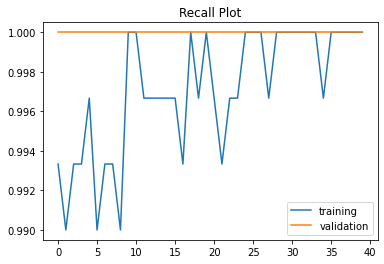

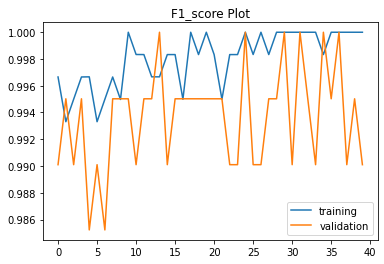

In [15]:
# See Plotted Metrics
plot_curves(history)

In [16]:
# Evaluate the model on Test set using best finetuned model
model.load_weights(f"{model_name}_{model_type}_finetuned_best_val_f1_score.h5")
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), F1Score(1, 'micro', threshold=0.5)]
)
results = model.evaluate(test_ds, verbose=2)

7/7 - 1s - loss: 0.0376 - accuracy: 0.9950 - precision: 0.9901 - recall: 1.0000 - f1_score: 0.9950 - 1s/epoch - 208ms/step
